# Exercise 14

## Predict rating using LSTM


In [1]:
!pip install livelossplot

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem.snowball import SnowballStemmer
import tensorflow as tf
#import tensorflow_model_analysis as tfma
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from livelossplot import PlotLossesKeras
%matplotlib inline

Using TensorFlow backend.


In [3]:
dataTraining = pd.read_csv('https://github.com/albahnsen/AdvancedMethodsDataAnalysisClass/raw/master/datasets/dataTraining.zip', encoding='UTF-8', index_col=0)

In [4]:
plots = dataTraining['plot']
y = (dataTraining['rating'] >= dataTraining['rating'].mean()).astype(int)

In [5]:
plots

3107    most is the story of a single father who takes...
900     a serial killer decides to teach the secrets o...
6724    in sweden ,  a female blackmailer with a disfi...
4704    in a friday afternoon in new york ,  the presi...
2582    in los angeles ,  the editor of a publishing h...
                              ...                        
8417    " our marriage ,  their wedding .  "  it ' s l...
1592    the wandering barbarian ,  conan ,  alongside ...
1723    like a tale spun by scheherazade ,  kismet fol...
7605    mrs .  brisby ,  a widowed mouse ,  lives in a...
215     tinker bell journey far north of never land to...
Name: plot, Length: 7895, dtype: object

In [6]:
y

3107    1
900     0
6724    1
4704    1
2582    1
       ..
8417    0
1592    0
1723    0
7605    1
215     1
Name: rating, Length: 7895, dtype: int64

# Exercise 14.1

- Remove stopwords 
- Lowercase
- split the text in words 
- pad_sequences

In [7]:
X_ = plots.to_list()

In [8]:
X_[0]

'most is the story of a single father who takes his eight year - old son to work with him at the railroad drawbridge where he is the bridge tender .  a day before ,  the boy meets a woman boarding a train ,  a drug abuser .  at the bridge ,  the father goes into the engine room ,  and tells his son to stay at the edge of the nearby lake .  a ship comes ,  and the bridge is lifted .  though it is supposed to arrive an hour later ,  the train happens to arrive .  the son sees this ,  and tries to warn his father ,  who is not able to see this .  just as the oncoming train approaches ,  his son falls into the drawbridge gear works while attempting to lower the bridge ,  leaving the father with a horrific choice .  the father then lowers the bridge ,  the gears crushing the boy .  the people in the train are completely oblivious to the fact a boy died trying to save them ,  other than the drug addict woman ,  who happened to look out her train window .  the movie ends ,  with the man wande

### Stop words

In [9]:
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
stop_words = set(stopwords.words('english'))

In [11]:
for i in range(len(X_)):
  word_tokens = word_tokenize(X_[i])
  filtered_sentence = [w for w in word_tokens if not w in stop_words] 
  X_[i] = ' '.join(filtered_sentence)

In [12]:
#X_[0:1]
X_[0]

'story single father takes eight year - old son work railroad drawbridge bridge tender . day , boy meets woman boarding train , drug abuser . bridge , father goes engine room , tells son stay edge nearby lake . ship comes , bridge lifted . though supposed arrive hour later , train happens arrive . son sees , tries warn father , able see . oncoming train approaches , son falls drawbridge gear works attempting lower bridge , leaving father horrific choice . father lowers bridge , gears crushing boy . people train completely oblivious fact boy died trying save , drug addict woman , happened look train window . movie ends , man wandering new city , meets woman , longer drug addict , holding small baby . relevant narratives run parallel , namely one female drug - addict , meet climax tumultuous film .'

### Lowercase

In [13]:
for i in range(len(X_)):
  X_[i] = X_[i].lower()

### Create vocabulary


In [14]:
voc = (set(''.join(X_).split()))

In [15]:
vocabulary = {x: idx + 1 for idx, x in enumerate(set(voc))}

In [16]:
words = [x.split() for x in X_]

In [17]:
len_words = pd.Series([len(x) for x in X_])

In [18]:
len_words.describe(percentiles=[.8, .9, .95, .975])

count    7895.000000
mean      515.398733
std       333.907391
min         0.000000
50%       451.000000
80%       736.000000
90%       969.000000
95%      1164.300000
97.5%    1351.650000
max      5810.000000
dtype: float64

### Split text

In [19]:
# to list the plots
max_plot_len = 1351
X_ = [x[:max_plot_len] for x in X_]

In [20]:
# Convert characters to int and pad
X_ = [[vocabulary[x1] for x1 in x if x1 in vocabulary.keys()] for x in X_]

### Pads to sequences

In [21]:
X_pad = sequence.pad_sequences(X_, maxlen=max_plot_len)

In [22]:
X_pad

array([[    0,     0,     0, ...,  8539, 10488, 32292],
       [    0,     0,     0, ..., 11051,   203, 32292],
       [    0,     0,     0, ..., 38736, 35204, 32292],
       ...,
       [    0,     0,     0, ...,  1520, 16161, 32292],
       [    0,     0,     0, ..., 33860, 38736, 32292],
       [    0,     0,     0, ..., 38736, 38736, 32292]], dtype=int32)

In [23]:
X_pad.shape

(7895, 1351)

# Exercise 14.2

Create a LSTM neural network to predict the rating of a movie

Calculate the testing set accuracy

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.33, random_state=42)

In [25]:
dims = X_train.shape[1]

In [41]:
K.clear_session()

model = Sequential()

model.add(Embedding(len(vocabulary), 1200, input_length=max_plot_len))
model.add(LSTM(120))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid', use_bias=True))

model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])

model.summary()     

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1351, 1200)        50360400  
_________________________________________________________________
lstm_1 (LSTM)                (None, 120)               634080    
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 121       
Total params: 50,994,601
Trainable params: 50,994,601
Non-trainable params: 0
_________________________________________________________________


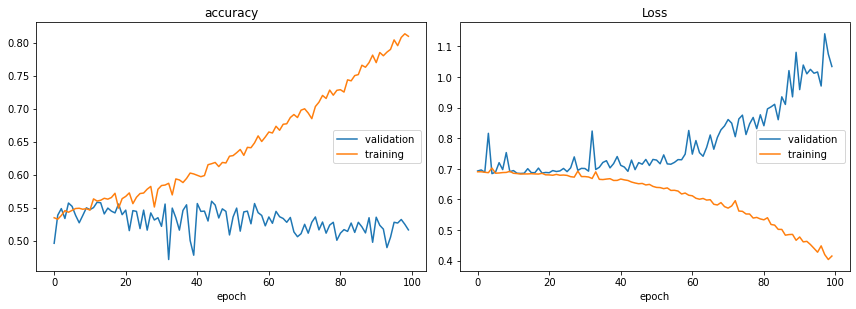

accuracy
	validation       	 (min:    0.472, max:    0.560, cur:    0.517)
	training         	 (min:    0.533, max:    0.814, cur:    0.810)
Loss
	validation       	 (min:    0.684, max:    1.141, cur:    1.034)
	training         	 (min:    0.404, max:    0.702, cur:    0.415)


In [43]:
fBestModel = 'best_model.h5'
early_stop = EarlyStopping(monitor='accuracy', patience=2, verbose=1) 
best_model = ModelCheckpoint(fBestModel, verbose=1, save_best_only=True)


model.fit(X_train, y_train,         
          validation_data=[X_test, y_test],
          class_weight='balanced',
          epochs=100,
          batch_size=528,
          verbose = 1,
          #validation_split=0.3,
          callbacks=[best_model, early_stop, PlotLossesKeras()])

In [44]:
y_pred_genres = model.predict_proba(X_test, verbose=1)

2606/2606 [==============================] - 69s 27ms/step


In [45]:
roc_auc_score(y_test, y_pred_genres, average='macro') 

0.5087174333889964

In [46]:
y_pred = model.predict_classes(X_test)[:,0]
print((y_pred == y_test).mean())

0.5165003837298542
